In [1]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm #https://github.com/tqdm/tqdm

import warnings
warnings.filterwarnings("ignore")
import gc; gc.enable()

In [2]:
# from LGBWrapper import RegressorModel
# from LGBWrapper import LGBWrapper_regr
# from sklearn.model_selection import KFold, GroupKFold

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVR
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor

In [3]:
#Display setting to see everything in each row
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 600)

In [4]:
gc.collect()

40

# Helper function

In [7]:
def check_labels_in_train_labels(df):
    temp=label(df)
    temp=pd.merge(train_labels, temp, on='game_session')
    error= sum(temp.accuracy_group==temp.group)
    print( "Num correct labels are:", error )
    print( "Percentage of correctness:", round(error*100/len(df),2))
    
def label(df):
    group=[]
    for i in df.ASM_accuracy:
        if i==0:
            group.append(0)
        elif i==1: 
            group.append(3)
        elif i>=1/2:
            group.append(2)
        elif i<1/2:
            group.append(1)
        else:
            print('invalid')
    result=pd.DataFrame({})
    result['game_session']=df.game_session
    result['group']=group
    return result

In [8]:
def cat_col(df):
    cat_col_list=[]
    for col in df.columns:
        if (df[col].dtype=='O'):
            cat_col_list.append(col)
    return cat_col_list

In [13]:
def cappa_cohen(estimator, X, y ):
    max_rat=3
    a1=estimator.predict(X)
    a2=y
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e

# Input data

In [10]:
#Import official data
X_test = pd.read_csv("output/X_test.csv")
X_train = pd.read_csv("output/X_train.csv")
label = pd.read_csv("output/label.csv")
sample_submission=pd.read_csv('input/sample_submission.csv')

X_train=X_train.drop(['ASM_GT','ASM_accuracy','ASM_correct', 'ASM_incorrect',
                     'Assessment_title', 'game_session', 'installation_id'],axis=1)

# Simple Classification

In [14]:
gbc=GradientBoostingClassifier()
xgb=XGBClassifier()
lgbm=LGBMClassifier()
rfc = RandomForestClassifier()

In [15]:
cat_col(X_train)

[]

In [84]:
# %time
# scores1=cross_val_score(gbc,X_train, label, cv=3,scoring=cappa_cohen)
# print("Done")
# scores2=cross_val_score(xgb,X_train, label, cv=3,scoring=cappa_cohen)
# print("Done")
# scores3=cross_val_score(lgbm,X_train, label, cv=3,scoring=cappa_cohen)
# print("Done")
# scores4=cross_val_score(rfc, X_train, label, cv=3,scoring=cappa_cohen)

In [18]:
print(scores1.mean(), scores1.std())
print(scores2.mean(), scores2.std())
print(scores3.mean(), scores3.std())
print(scores4.mean(), scores4.std())

0.8387022896249613 0.010159699620524383
0.8302070795199619 0.0014718950456766768
0.862941531195613 0.007017078340231931
0.7185412839061321 0.012911907466836552


In [21]:
#Prediction
X_test=X_test[X_train.columns]
lgbm.fit(X_train,label)
prediction=lgbm.predict(X_test)

In [22]:
pd.Series(prediction).value_counts()

0    658
3    327
2      9
1      6
dtype: int64

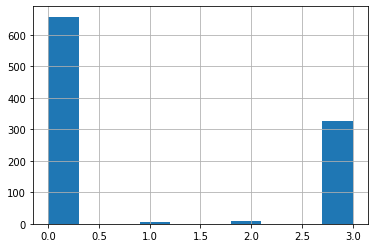

In [26]:
pd.Series(prediction).hist()

# More Complicated Classification 

First classify 0 and non-0 group, and then classify 1,2,3

In [76]:
def custom_model(train,label,test): #Label here is a dataframe with accuracy stored in 'group'
    
    #################Training###################
    lgbm_bin=LGBMClassifier()
    lgbm_bin.fit(train, [1 if i>0 else 0 for i in label.group]) #train on binary label
    
    #Create a new training set for 3 targets classifier
    bin_prediction=lgbm_bin.predict(train)
    non_zero_index=[i for i in range(len(bin_prediction)) if bin_prediction[i]==1]
    train_new=train.iloc[non_zero_index]
    label_new=[label.group[i]  for i in non_zero_index ]
    
    lgbm_three=LGBMClassifier()
    lgbm_three.fit(train_new,label_new)
    
    #################Predicting###################
    y_bin=lgbm_bin.predict(X_test)
    non_zero_index=[i for i in range(len(y_bin)) if y_bin[i]==1]
    test_new=test.iloc[non_zero_index]
    
    y_three=lgbm_three.predict(test_new)
    
    y=y_bin
    for index, new_value in zip(non_zero_index, y_three):
        y[index]=new_value
    
    return y

In [77]:
prediction=custom_model(X_train, label, X_test )

In [80]:
pd.Series(prediction).value_counts()

0    701
3    287
1      7
2      5
dtype: int64

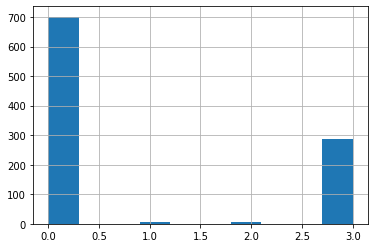

In [81]:
pd.Series(prediction).hist()

In [83]:
X_train.shape

(18837, 533)